# kaggle에서 데이터 다운로드

참고: https://callmescone.tistory.com/258

In [ ]:
!pip install kaggle

# Kaggle 로그인 후 프로필 클릭 -> Settings의 API에서 Create New Token 클릭 -> kaggle.json 파일 다운로드
# 아래 코드 실행하여 kaggle.json 파일 업로드
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jjumu1263","key":"d3bed9bf4eb744911ca6450e9ff2ec5d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 데이터셋 다운로드
!kaggle datasets download -d miadul/hypertension-risk-prediction-dataset

# 압축 해제
!unzip hypertension-risk-prediction-dataset.zip -d ./hypertension_data

Dataset URL: https://www.kaggle.com/datasets/miadul/hypertension-risk-prediction-dataset
License(s): apache-2.0
  0% 0.00/22.3k [00:00<?, ?B/s]
100% 22.3k/22.3k [00:00<00:00, 75.4MB/s]
Archive:  hypertension-risk-prediction-dataset.zip
  inflating: ./hypertension_data/hypertension_dataset.csv  


# 데이터 불러오기

In [ ]:
import pandas as pd

df = pd.read_csv("./hypertension_data/hypertension_dataset.csv")
print(df.head())
print(df.info())

   Age  Salt_Intake  Stress_Score       BP_History  Sleep_Duration   BMI  \
0   69          8.0             9           Normal             6.4  25.8   
1   32         11.7            10           Normal             5.4  23.4   
2   78          9.5             3           Normal             7.1  18.7   
3   38         10.0            10     Hypertension             4.2  22.1   
4   41          9.8             1  Prehypertension             5.8  16.2   

      Medication Family_History Exercise_Level Smoking_Status Has_Hypertension  
0            NaN            Yes            Low     Non-Smoker              Yes  
1            NaN             No            Low     Non-Smoker               No  
2            NaN             No       Moderate     Non-Smoker               No  
3  ACE Inhibitor             No            Low     Non-Smoker              Yes  
4          Other             No       Moderate     Non-Smoker               No  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985 en

In [ ]:
from sklearn.model_selection import train_test_split

# 입력 특징(X), 고혈압 여부(y) 분리
X = df.drop("Has_Hypertension", axis=1)
y = df["Has_Hypertension"]

# 2. train/test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (1588, 10) (1588,)
Test shape: (397, 10) (397,)


# 데이터 전처리

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
class_names = ['Age', 'Salt_Intake', 'Stress_Score', 'BP_History', 'Sleep_Duration', 'BMI', 'Medication', 'Family_History', 'Exercise_Level', 'Smoking_Status', 'Has_Hypertension']
train_counter = collections.Counter(y_train)
test_counter = collections.Counter(y_test)

missing_data = df.isnull().sum()
data_cleaned = df.dropna()

#Handle missing values in 'Medication' column before encoding
X_train['Medication'] = X_train['Medication'].fillna('Unknown')
X_test['Medication'] = X_test['Medication'].fillna('Unknown')

#원-핫 인코딩
X_train_encoded = pd.get_dummies(X_train, columns=['BP_History', 'Medication', 'Family_History', 'Exercise_Level', 'Smoking_Status'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=['BP_History', 'Medication', 'Family_History', 'Exercise_Level', 'Smoking_Status'], drop_first=True)


#Ensure consistent columns after one-hot encoding
train_cols = X_train_encoded.columns
test_cols = X_test_encoded.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_encoded[c] = 0
missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_encoded[c] = 0

X_test_encoded = X_test_encoded[train_cols]
#숫자형으로 변환
X_train_encoded = X_train_encoded.astype("float32")
X_test_encoded = X_test_encoded.astype("float32")
y_train = y_train.map({"No": 0, "Yes": 1}).astype("int32")
y_test  = y_test.map({"No": 0, "Yes": 1}).astype("int32")

print(y_train.unique())
#데이터 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

print("클래스 분포 (Train):", train_counter)
print("클래스 분포 (Test):", test_counter)
print("결측치 확인:\n", missing_data)

[1 0]
클래스 분포 (Train): Counter({'Yes': 826, 'No': 762})
클래스 분포 (Test): Counter({'Yes': 206, 'No': 191})
결측치 확인:
 Age                   0
Salt_Intake           0
Stress_Score          0
BP_History            0
Sleep_Duration        0
BMI                   0
Medication          799
Family_History        0
Exercise_Level        0
Smoking_Status        0
Has_Hypertension      0
dtype: int64


데이터 크기: (1985, 11)

데이터 타입 및 결측치:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985 entries, 0 to 1984
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1985 non-null   int64  
 1   Salt_Intake       1985 non-null   float64
 2   Stress_Score      1985 non-null   int64  
 3   BP_History        1985 non-null   object 
 4   Sleep_Duration    1985 non-null   float64
 5   BMI               1985 non-null   float64
 6   Medication        1186 non-null   object 
 7   Family_History    1985 non-null   object 
 8   Exercise_Level    1985 non-null   object 
 9   Smoking_Status    1985 non-null   object 
 10  Has_Hypertension  1985 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 170.7+ KB
None

기본 통계치:

                Age  Salt_Intake  Stress_Score BP_History  Sleep_Duration  \
count   1985.000000  1985.000000   1985.000000       1985     1985.000000   
unique        

/tmp/ipython-input-2515903258.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Has_Hypertension", data=df, palette="Set2")


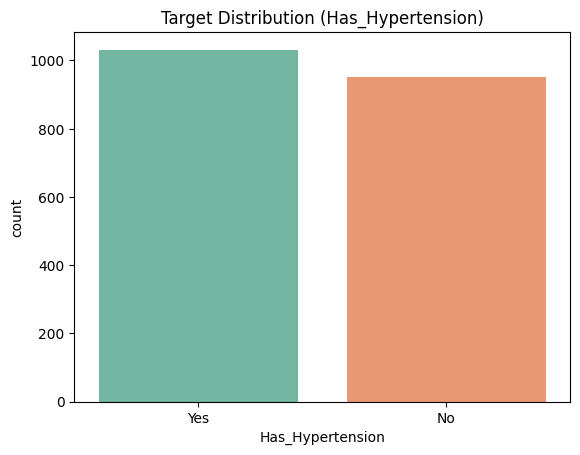

타깃 분포:
 Has_Hypertension
Yes    0.519899
No     0.480101
Name: proportion, dtype: float64

결측치 개수:
 Age                   0
Salt_Intake           0
Stress_Score          0
BP_History            0
Sleep_Duration        0
BMI                   0
Medication          799
Family_History        0
Exercise_Level        0
Smoking_Status        0
Has_Hypertension      0
dtype: int64


/tmp/ipython-input-2515903258.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="pastel")


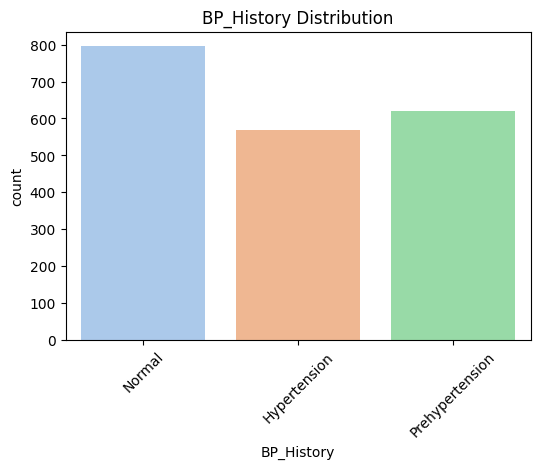

/tmp/ipython-input-2515903258.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="pastel")


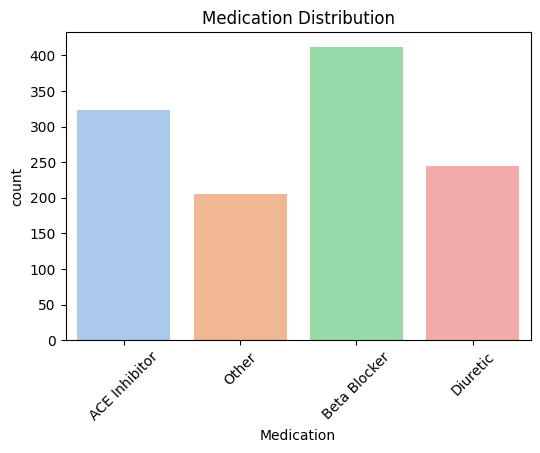

/tmp/ipython-input-2515903258.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="pastel")


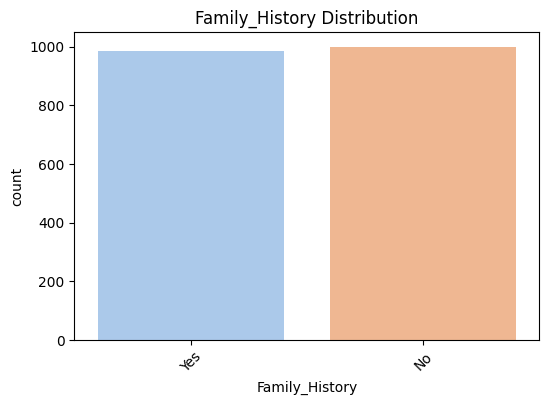

/tmp/ipython-input-2515903258.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="pastel")


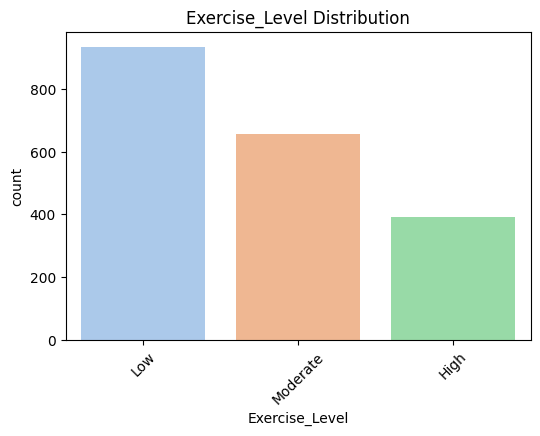

/tmp/ipython-input-2515903258.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="pastel")


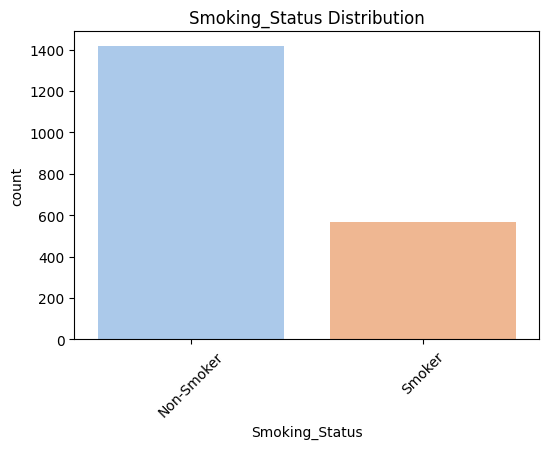

/tmp/ipython-input-2515903258.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Has_Hypertension", y=col, data=df, palette="Set3")


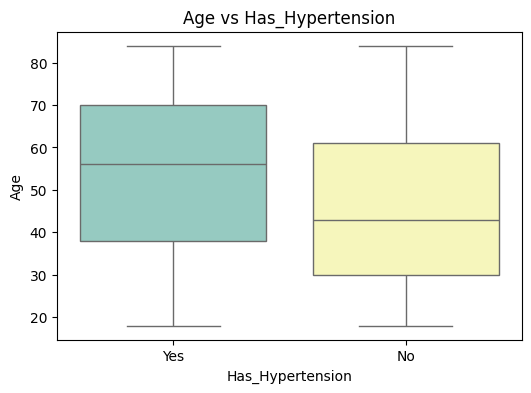

/tmp/ipython-input-2515903258.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Has_Hypertension", y=col, data=df, palette="Set3")


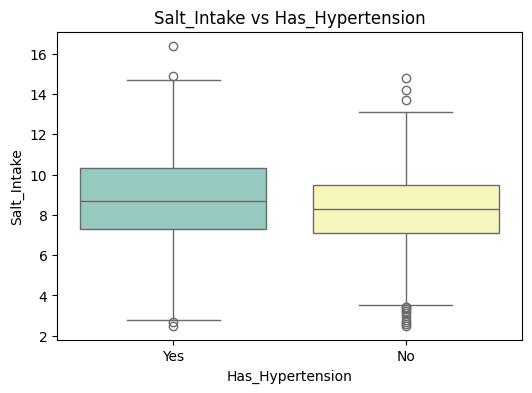

/tmp/ipython-input-2515903258.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Has_Hypertension", y=col, data=df, palette="Set3")


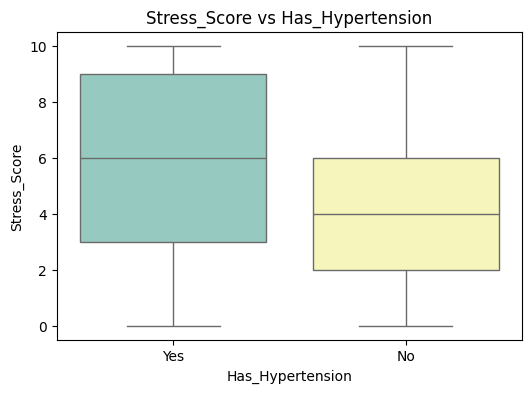

/tmp/ipython-input-2515903258.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Has_Hypertension", y=col, data=df, palette="Set3")


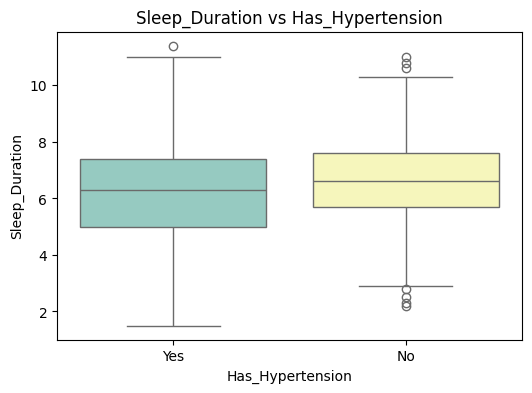

/tmp/ipython-input-2515903258.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Has_Hypertension", y=col, data=df, palette="Set3")


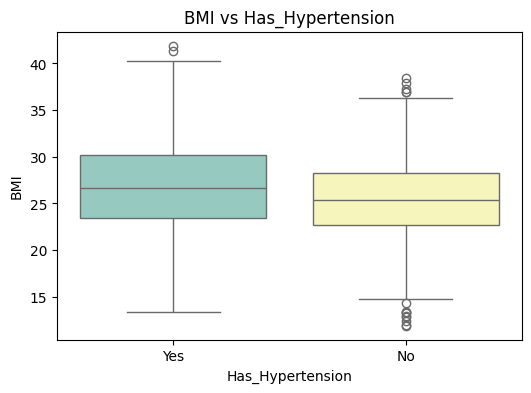

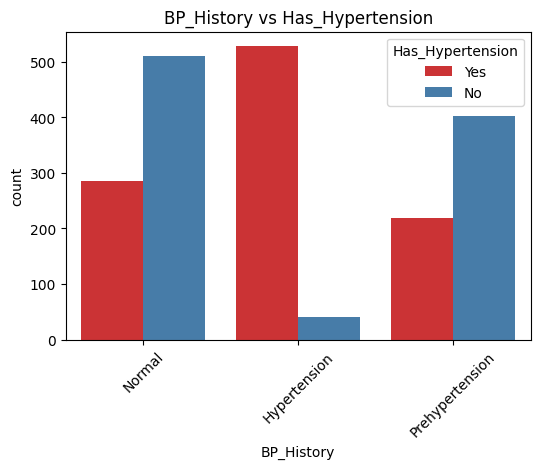

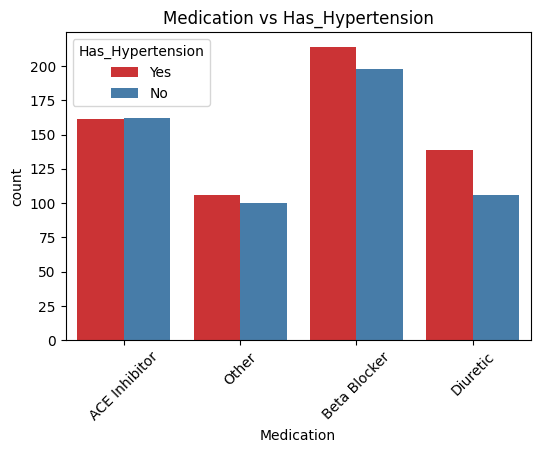

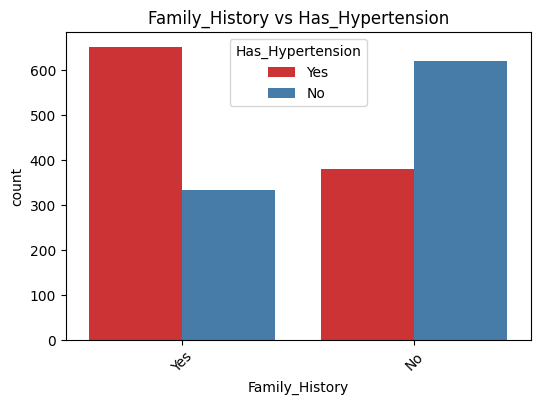

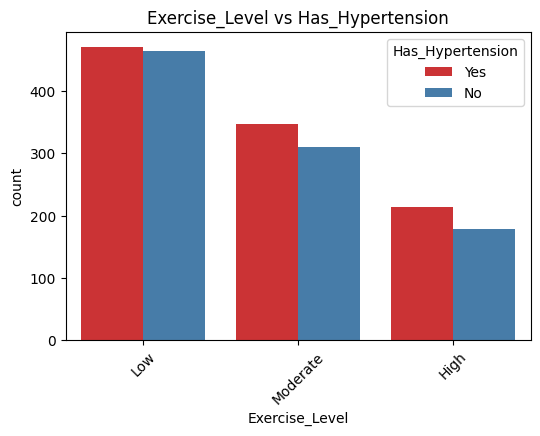

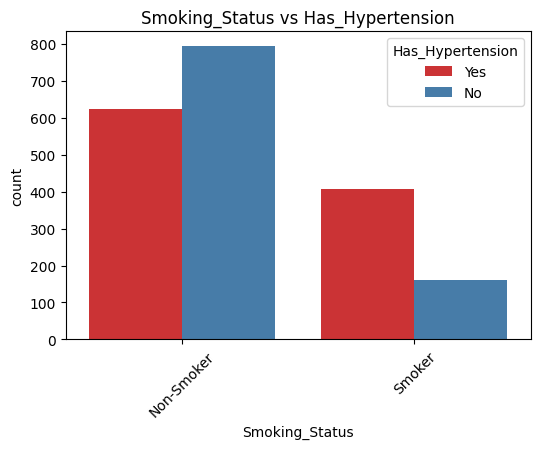

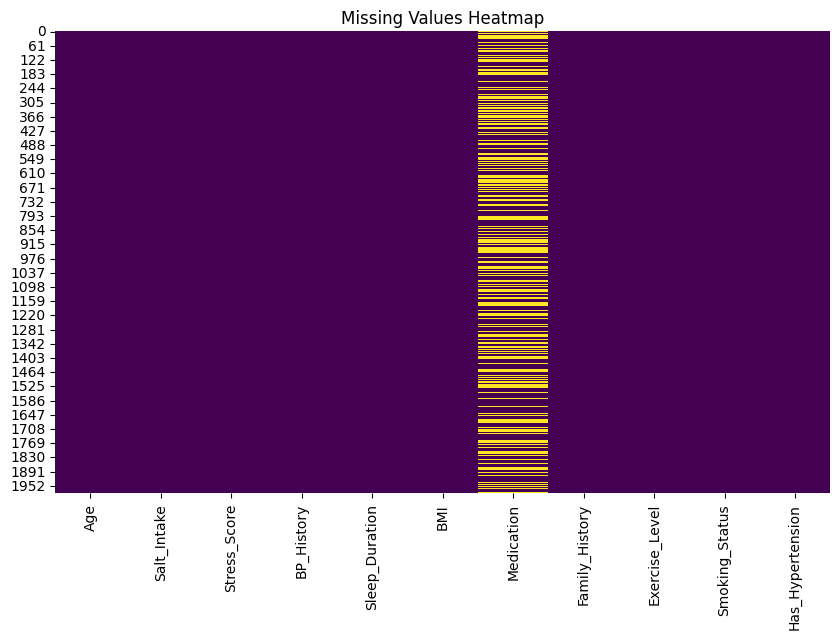

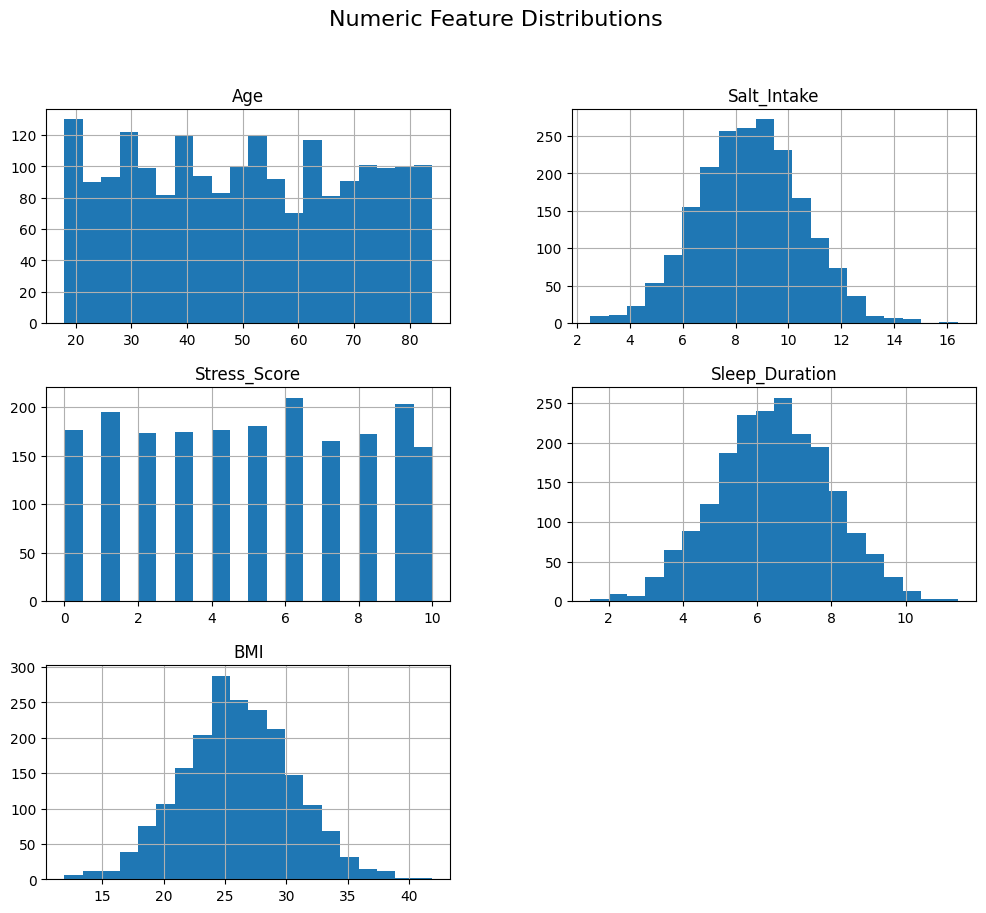

/tmp/ipython-input-2515903258.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Has_Hypertension", data=df, palette="Set2")


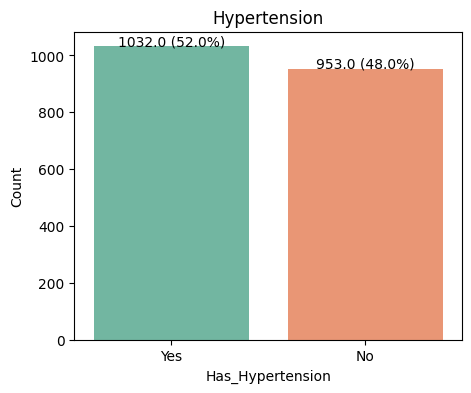

In [ ]:
print("데이터 크기:", df.shape)
print("\n데이터 타입 및 결측치:\n")
print(df.info())
print("\n기본 통계치:\n")
print(df.describe(include="all"))

sns.countplot(x="Has_Hypertension", data=df, palette="Set2")
plt.title("Target Distribution (Has_Hypertension)")
plt.show()

print("타깃 분포:\n", df["Has_Hypertension"].value_counts(normalize=True))
print("\n결측치 개수:\n", df.isnull().sum())

cat_cols = df.select_dtypes(include=["object"]).columns.drop("Has_Hypertension")
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df, palette="pastel")
    plt.title(f"{col} Distribution")
    plt.xticks(rotation=45)
    plt.show()

num_cols = df.select_dtypes(include=["int64", "float64"]).columns
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Has_Hypertension", y=col, data=df, palette="Set3")
    plt.title(f"{col} vs Has_Hypertension")
    plt.show()

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue="Has_Hypertension", data=df, palette="Set1")
    plt.title(f"{col} vs Has_Hypertension")
    plt.xticks(rotation=45)
    plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

df[num_cols].hist(figsize=(12, 10), bins=20)
plt.suptitle("Numeric Feature Distributions", fontsize=16)
plt.show()

# 모델 정의 및 학습

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
print("X_train_encoded dtypes:\n", X_train_encoded.dtypes)
print("X_test_encoded dtypes:\n", X_test_encoded.dtypes)

X_train_encoded dtypes:
 Age                           float32
Salt_Intake                   float32
Stress_Score                  float32
Sleep_Duration                float32
BMI                           float32
BP_History_Normal             float32
BP_History_Prehypertension    float32
Medication_Beta Blocker       float32
Medication_Diuretic           float32
Medication_Other              float32
Medication_Unknown            float32
Family_History_Yes            float32
Exercise_Level_Low            float32
Exercise_Level_Moderate       float32
Smoking_Status_Smoker         float32
dtype: object
X_test_encoded dtypes:
 Age                           float32
Salt_Intake                   float32
Stress_Score                  float32
Sleep_Duration                float32
BMI                           float32
BP_History_Normal             float32
BP_History_Prehypertension    float32
Medication_Beta Blocker       float32
Medication_Diuretic           float32
Medication_Other         

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 테스트

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)
loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"테스트 데이터 정확도: {acc:.4f}")
print(f"테스트 데이터 손실값: {loss:.4f}")

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5446 - loss: 0.6829 - val_accuracy: 0.7233 - val_loss: 0.6235
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7654 - loss: 0.5833 - val_accuracy: 0.8113 - val_loss: 0.4754
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8401 - loss: 0.4232 - val_accuracy: 0.8868 - val_loss: 0.3314
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8716 - loss: 0.2996 - val_accuracy: 0.8931 - val_loss: 0.2726
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9091 - loss: 0.2447 - val_accuracy: 0.8931 - val_loss: 0.2500
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9038 - loss: 0.2219 - val_accuracy: 0.8962 - val_loss: 0.2424
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9089 - loss: 0.2132 - val_accuracy: 0.8931 - val_loss: 0.2401
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9185 - loss: 0.1918 - val_accuracy: 0.8962 - val_loss: